# Modeling

Modeling in machine learning refers to the process of creating a mathematical representation of a system or phenomenon. This representation, called a model, is then used to make predictions or decisions about new data. There are many types of models, such as linear regression, decision trees, and neural networks, each with their own strengths and weaknesses.

When creating a model, it is important to be careful about overfitting, which occurs when a model is too complex and fits the training data too well, but performs poorly on new data. It's also important to be careful about underfitting, which occurs when a model is too simple and doesn't capture the complexity of the system or phenomenon it is trying to represent. Additionally, it's important to be mindful of the potential for bias in the data used to train the model, as well as in the model itself.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import plot_importance
from xgboost import plot_tree

In [2]:
data = pd.read_csv("customer_data.csv")
data.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Transaction_Count_per_Contact,Loyal_Customer,Creditworthiness,Cr_Util_Rate,Attrition_Flag
0,0.0,-1.0,0.5,-1.0,0.0,0.5,0.0,0.0,0.5,-1.0,...,2.627193,-1.065558,-0.694444,3.911017,-0.239583,-0.500000,0.0,-0.284692,-0.238398,0
1,0.0,0.0,1.5,0.0,-1.0,-0.5,0.0,0.0,1.0,-1.0,...,3.530702,-1.008702,-0.944444,12.762712,-0.147917,-0.666667,0.0,-0.618989,-0.147921,0
2,0.0,-1.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,...,8.149123,-0.778186,-1.305556,6.911017,-0.366667,-0.907407,0.0,2.281101,-0.365955,0
3,-1.0,0.0,1.0,-1.0,0.0,-0.5,0.0,-1.0,-0.5,2.0,...,2.934211,-1.055115,-1.305556,6.911017,1.216667,-0.537037,-1.0,-0.228374,1.216900,0
4,-1.0,-1.0,0.5,-1.0,0.0,0.5,0.0,-2.0,0.5,-1.0,...,6.311404,-1.192419,-1.083333,7.618644,-0.366667,-1.277778,-1.0,0.723351,-0.365955,0


In [3]:
### splitting data
X = data.iloc[:,:-1]
y = data["Attrition_Flag"]

In [4]:
print(X.shape)
print(y.shape)

(10127, 23)
(10127,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=69)

Setting the random_state variable to a specific value, such as **69** in this case, ensures that the results of the code will be reproducible. This means that if someone else runs the same code with the same random state, they will get exactly the same results. This is useful when want to ensure that the results are not affected by randomness or want to share the results with others and want them to be able to reproduce the work.

In [6]:
sm = SMOTE(random_state = 69, sampling_strategy = 1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)

The above line is creating an instance of Synthetic Minority Over-sampling Technique (**SMOTE**) which is an *over-sampling* technique for imbalanced datasets. This technique is used to balance the class distribution by creating synthetic samples. The sampling_strategy variable is set to 1.0, meaning that SMOTE will create as many synthetic samples as the number of samples in the minority class. The random_state variable is set to 69 to make the results reproducible.

It is usually applied to the training dataset to balance the class distribution before training a model.It's not applied to the test dataset because the test dataset should be representative of the real-world data that the model will be applied to. The test dataset should be as close as possible to the real-world data, including the class imbalance. In other words, if the real-world data is imbalanced, the test dataset should also be imbalanced.

Applying SMOTE to the test dataset would artificially balance the class distribution and give an overestimate of the model's performance. In addition, it would also make the test dataset no longer representative of the real-world data, which would lead to unreliable evaluation of the model's performance. In short, applying SMOTE only to the training dataset and not the test dataset maintains the integrity of the test data and allows for a more accurate evaluation of the model's performance.

In [7]:
print(X_train.shape)
print(y_train.shape)

(13584, 23)
(13584,)


# XGBoost

XGBoost is an implementation of gradient boosting that is used for supervised learning problems, such as classification and regression. It is an ensemble method, which means that it combines the predictions of multiple simpler models to create a more accurate and stable final prediction.

The basic idea behind gradient boosting is to fit a sequence of simple models, such as decision trees, to the data and then combine their predictions. Each new model is trained to correct the errors made by the previous models in the sequence. The final prediction is made by combining the predictions of all the models in the sequence.

XGBoost uses a specific type of decision tree called a "gradient tree boosting" model, which is more efficient than traditional decision trees and can handle *missing data* and *categorical variables*. It also uses a technique called **regularization** to prevent overfitting, which is a common problem when training decision tree models.

#### How it works?
XGBoost fits the first tree to the data. This tree is called the base learner. The objective of this tree is to fit the data as well as possible. The next step is to add more trees to the ensemble. Each new tree is trained to correct the errors made by the previous trees in the ensemble. The objective of each new tree is to minimize the residual error, which is the difference between the true labels and the current predictions. XGBoost also regularization to prevent overfitting. This is done by adding a penalty term to the objective function that is being minimized. The penalty term is proportional to the complexity of the model, which discourages the model from fitting the noise in the data.

The mentioned steps are repeated for a fixed number of iterations or until a stopping criterion is met. After the ensemble of trees is trained, XGBoost makes predictions by combining the predictions of all the trees in the ensemble. The final prediction for a given input is calculated as the weighted sum of the predictions of all the trees, where the weight of each tree is proportional to its importance. XGBoost also provides the feature of fine-tuning the model using techniques like cross-validation, grid search etc.

In [8]:
xgb_model = xgb.XGBClassifier(random_state=69, use_label_encoder=False, n_jobs=-1)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=69,
              reg_alpha=0, reg_lambda=1, ...)

- *random_state=69*: This sets the seed for the random number generator used to initialize the model. Setting the random seed ensures that the results are reproducible.
- *use_label_encoder=False*: This disables the use of a label encoder, which is used to convert categorical variables to numerical values.
- *n_jobs=-1*: This sets the number of parallel threads to use for fitting the model. A value of -1 means that the number of threads will be set to the number of cores in the system.

In [9]:
xgb_model.score(X_test, y_test)

0.9689042448173741

In [10]:
y_pred = xgb_model.predict(X_test)

In [11]:
len(y_pred)

2026

The classifier object is trained on the training dataset, which is used to learn the relationship between the features and the target variable. The predict() method uses this learned relationship to make predictions for new samples.

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1708
           1       0.90      0.90      0.90       318

    accuracy                           0.97      2026
   macro avg       0.94      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026



In [13]:
confusion_matrix(y_test, y_pred)

array([[1678,   30],
       [  33,  285]], dtype=int64)

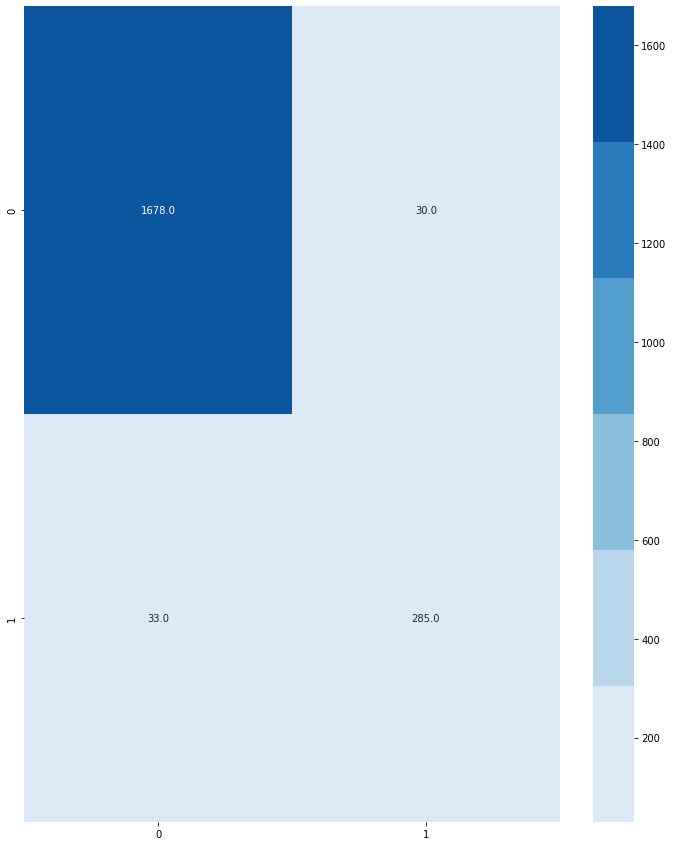

In [14]:
cf_matrix = confusion_matrix(y_test, y_pred)
colormap = sns.color_palette("Blues")
plt.figure(figsize=(12,15));
sns.heatmap(cf_matrix, annot=True,cmap=colormap,fmt=".1f");

----------------------------------------------------

# Given the new client, will this client churn?

In [15]:
feature_ranges = {
    "Customer_Age" :(-2.0, 2.0),
    "Gender": (-1.0, 0.0),
    "Dependent_count": (-1.0, 1.5),
    "Education_Level": (-1.0, 1.0),
    "Marital_Status": (-1.0, 1.0),
    "Income_Category": (-0.5, 1.5),
    "Card_Category": (0.0, 3.0),
    "Months_on_book": (-2.0, 1.0),
    "Total_Relationship_Count": (-1.5, 1.0),
    "Months_Inactive_12_mon": (-2.0, 4.0),
    "Contacts_Count_12_mon": (-2.0, 4.0),
    "Credit_Limit": (-0.3654273127753303, 3.520352422907489),
    "Total_Revolving_Bal": (-0.895438596491228, 0.8708771929824561),
    "Avg_Open_To_Buy": (-0.4067022086824067, 3.6372370964907135),
    "Total_Amt_Chng_Q4_Q1": (-3.2280701754385968, 11.671052631578949),
    "Total_Trans_Amt": (-1.3107716109069811, 5.641075227228776),
    "Total_Trans_Ct": (-1.5833333333333333, 2.0),
    "Total_Ct_Chng_Q4_Q1": (-2.9745762711864407, 12.76271186440678),
    "Avg_Utilization_Ratio": (-0.3666666666666666, 1.7145833333333331),
    "Transaction_Count_per_Contact": (-1.2777777777777777, 3.87037037037037),
    "Loyal_Customer": (-1.0, 0.0),
    "Creditworthiness": (-0.7455937133620327, 8.887382419041861),
    "Cr_Util_Rate": (-0.3659547645100451, 1.7149103774907906),
}

In [16]:
client_data = {}

# generate random values for each feature
for feature, range_ in feature_ranges.items():
    if isinstance(range_, tuple):
        client_data[feature] = np.random.uniform(range_[0], range_[1])
    else:
        client_data[feature] = np.random.choice(range_)

# convert the dictionary to a numpy array
client_data = np.array(list(client_data.values()))

# reshape the array to 2D
client_data = client_data.reshape(1, -1)

client_data_df = pd.DataFrame(client_data, columns=feature_ranges.keys())

# make the prediction
y_pred_new = xgb_model.predict(client_data.reshape(1, -1))

# print the prediction
print(y_pred_new[0])

1


First define a dictionary called feature_ranges to specify the range of values for each feature. Then create a dictionary called client_data to store the synthetic client data. The numpy.random.uniform() function used to generate random values for continuous variables and numpy.random.choice() to generate random values for categorical variables. Finally, the dictionary converted to a numpy array and use the predict() method of the trained XGBoost model to make a prediction on the synthetic client data.

In [17]:
r = random.randint(0,len(y_pred))
random_cli = data.drop('Attrition_Flag', axis=1).iloc[r]
random_cli

Customer_Age                     0.000000
Gender                          -1.000000
Dependent_count                  0.500000
Education_Level                  0.000000
Marital_Status                   0.000000
Income_Category                  1.000000
Card_Category                    1.000000
Months_on_book                   0.000000
Total_Relationship_Count         1.000000
Months_Inactive_12_mon           0.000000
Contacts_Count_12_mon            0.000000
Credit_Limit                     3.520352
Total_Revolving_Bal             -0.895439
Avg_Open_To_Buy                  3.637237
Total_Amt_Chng_Q4_Q1            -0.197368
Total_Trans_Amt                 -0.837749
Total_Trans_Ct                  -0.361111
Total_Ct_Chng_Q4_Q1             -0.279661
Avg_Utilization_Ratio           -0.366667
Transaction_Count_per_Contact   -0.277778
Loyal_Customer                   0.000000
Creditworthiness                -0.567684
Cr_Util_Rate                    -0.365955
Name: 1021, dtype: float64

In [18]:
clients = client_data_df.append(random_cli, ignore_index=True)
clients["Attrition_Flag"] = [y_pred_new[0],y_pred[r]]
clients

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Transaction_Count_per_Contact,Loyal_Customer,Creditworthiness,Cr_Util_Rate,Attrition_Flag
0,-0.922602,-0.636636,-0.808553,-0.137822,-0.167263,0.879448,0.089292,-1.947065,0.680126,0.543382,...,-2.041813,1.618806,-0.264548,0.726572,-0.055530,-1.174300,-0.300741,8.661947,0.872520,1
1,0.000000,-1.000000,0.500000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,-0.197368,-0.837749,-0.361111,-0.279661,-0.366667,-0.277778,0.000000,-0.567684,-0.365955,0


# Hyper Parameter Tunning

Hyperparameter tuning is the process of systematically searching for the best combination of hyperparameters for a machine learning model. Hyperparameters are parameters that are not learned from the data during training, but are set before the training process begins. Examples of hyperparameters include the learning rate, number of trees in a random forest, and the regularization strength in a linear regression model. Hyperparameter tuning is important because the performance of a machine learning model can be significantly affected by the choice of hyperparameters. Choosing the right combination of hyperparameters can lead to better model performance, while choosing poorly can lead to suboptimal performance or overfitting.

There are several techniques for hyperparameter tuning, such as grid search, random search, and bayesian optimization. These techniques can be used to explore the hyperparameter space and find the best combination of hyperparameters for a given dataset and model.

*Ref: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook*

In [19]:
from hyperopt import hp, fmin, tpe

SEED = 314159265
random_state=SEED

# Define the search space for each hyperparameter
n_estimators_space = hp.quniform('n_estimators', 100, 1000, 1)
eta_space = hp.quniform('eta', 0.025, 0.5, 0.025)
max_depth_space = hp.choice('max_depth', np.arange(1, 14, dtype=int))
min_child_weight_space = hp.quniform('min_child_weight', 1, 6, 1)
subsample_space = hp.quniform('subsample', 0.5, 1, 0.05)
gamma_space = hp.quniform('gamma', 0.5, 1, 0.05)
colsample_bytree_space = hp.quniform('colsample_bytree', 0.5, 1, 0.05)

# Use the fmin function to find the best values for each hyperparameter
best_n_estimators = fmin(fn=lambda x: x, space=n_estimators_space, algo=tpe.suggest, max_evals=100)
best_eta = fmin(fn=lambda x: x, space=eta_space, algo=tpe.suggest, max_evals=100)
best_max_depth = fmin(fn=lambda x: x, space=max_depth_space, algo=tpe.suggest, max_evals=100)
best_min_child_weight = fmin(fn=lambda x: x, space=min_child_weight_space, algo=tpe.suggest, max_evals=100)
best_subsample = fmin(fn=lambda x: x, space=subsample_space, algo=tpe.suggest, max_evals=100)
best_gamma = fmin(fn=lambda x: x, space=gamma_space, algo=tpe.suggest, max_evals=100)
best_colsample_bytree = fmin(fn=lambda x: x, space=colsample_bytree_space, algo=tpe.suggest, max_evals=100)

# Create a dictionary of the best parameter values
best_params = {
    'n_estimators': [int(best_n_estimators['n_estimators'])],
    'eta': [round(best_eta['eta'],3)],
    'max_depth': [best_max_depth['max_depth']+1],
    'min_child_weight': [int(best_min_child_weight['min_child_weight'])],
    'subsample': [round(best_subsample['subsample'],2)],
    'gamma': [round(best_gamma['gamma'],2)],
    'colsample_bytree': [round(best_colsample_bytree['colsample_bytree'],2)],
    'eval_metric': ['auc'],
    'objective': ['binary:logistic'],
    'nthread': [4],
    'booster': ['gbtree'],
    'tree_method': ['exact'],
    'silent': [1],
    'seed': [random_state]
}


# Create the XGBoost model with the best parameter values
xgb_model = xgb.XGBClassifier(**best_params)

# Perform the grid search
#grid_search = GridSearchCV(xgb_model, best_params, cv = 5, n_jobs = -1, verbose = 1)
grid_search = GridSearchCV(xgb_model, best_params, cv = 5, n_jobs = -1, verbose = 1, error_score='raise')
grid_search.fit(X_train, y_train)

100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 199.19trial/s, best loss: 0.5]
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:58:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=['gbtree'],
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=[0.5],
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eta=[0.025],
                                     eval_metric=['auc'], gamma=[0.5],
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=...
                                     objective=['binary:logistic'],
                                     predictor=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree'], 'colsample_bytree': [0.5],
                         'eta': [0.025], 'eval_metric': ['auc'], 'gamma': [0.5],
                         'max_depth': [1], 'min_child_weight': [1],
                         'n_estimators': [100], 'nthread': [4],
                         'objective': ['binary:logistic'], 'seed': [314159265],
                         'silent': [1], 'subsample': [0.5],
                         'tree_method': ['exact']},
             verbose=1)

In [20]:
xgb_best_est = grid_search.best_estimator_
y_pred = xgb_best_est.predict(X_test)

In [21]:
print(accuracy_score(y_test, y_pred))

0.7769002961500494


There are a few reasons why the accuracy score we got after fine-tuning the model is lower than the previous score:

- Overfitting: It's possible that the previous model was overfitting the training data, and therefore performed well on the training set, but poorly on unseen data such as the test set. The fine-tuning process may have addressed this issue by introducing regularization, which can prevent overfitting.

- Data Leakage: It's possible that there is leakage of information from the test set into the training set. For example, if use the same dataset for both training and testing, the model will be able to learn from the test set, which is not the intended use, and this can lead to a false high accuracy score on the test set.

- Unbalanced Data: If the classes in the data are not balanced, i.e. the number of samples of one class is much larger than the number of samples of the other class, then a model can achieve a high accuracy score simply by predicting the majority class all the time.

- The model is not generalizing well: It's possible that the model is not generalizing well to new unseen data. This can happen if the model is too complex or if the features in the data are not informative enough.

- Hyperparameter tuning can also lead to a lower accuracy score if the optimal parameter values are not the same as the default values.

In [22]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.025, 'eval_metric': 'auc', 'gamma': 0.5, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 314159265, 'silent': 1, 'subsample': 0.5, 'tree_method': 'exact'}
0.8190523258618756


# Finding Important Features

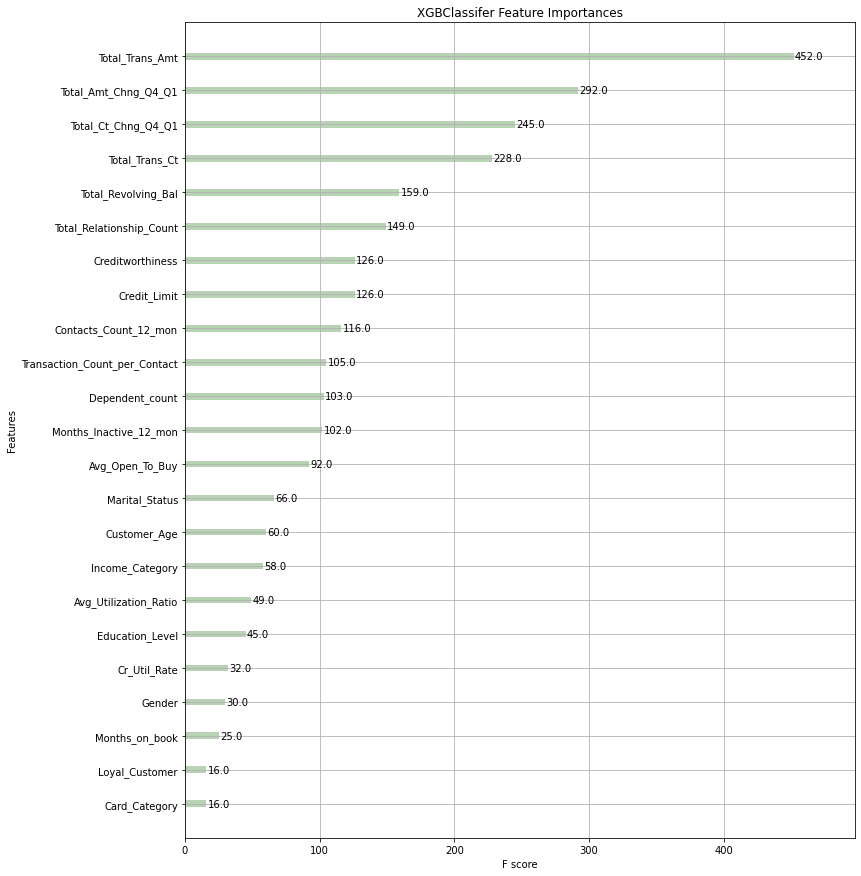

In [23]:
# https://stackoverflow.com/questions/40664776/how-to-change-size-of-plot-in-xgboost-plot-importance
# Train the model
xgbmodel = xgb.XGBClassifier()
xgbmodel.fit(X_train, y_train)

# Plot feature importances
fig, ax = plt.subplots(figsize=(12, 15))
plot_importance(xgbmodel, ax=ax, color='#b7d3b3')
plt.title("XGBClassifer Feature Importances");
plt.show();

<Figure size 5760x3600 with 0 Axes>

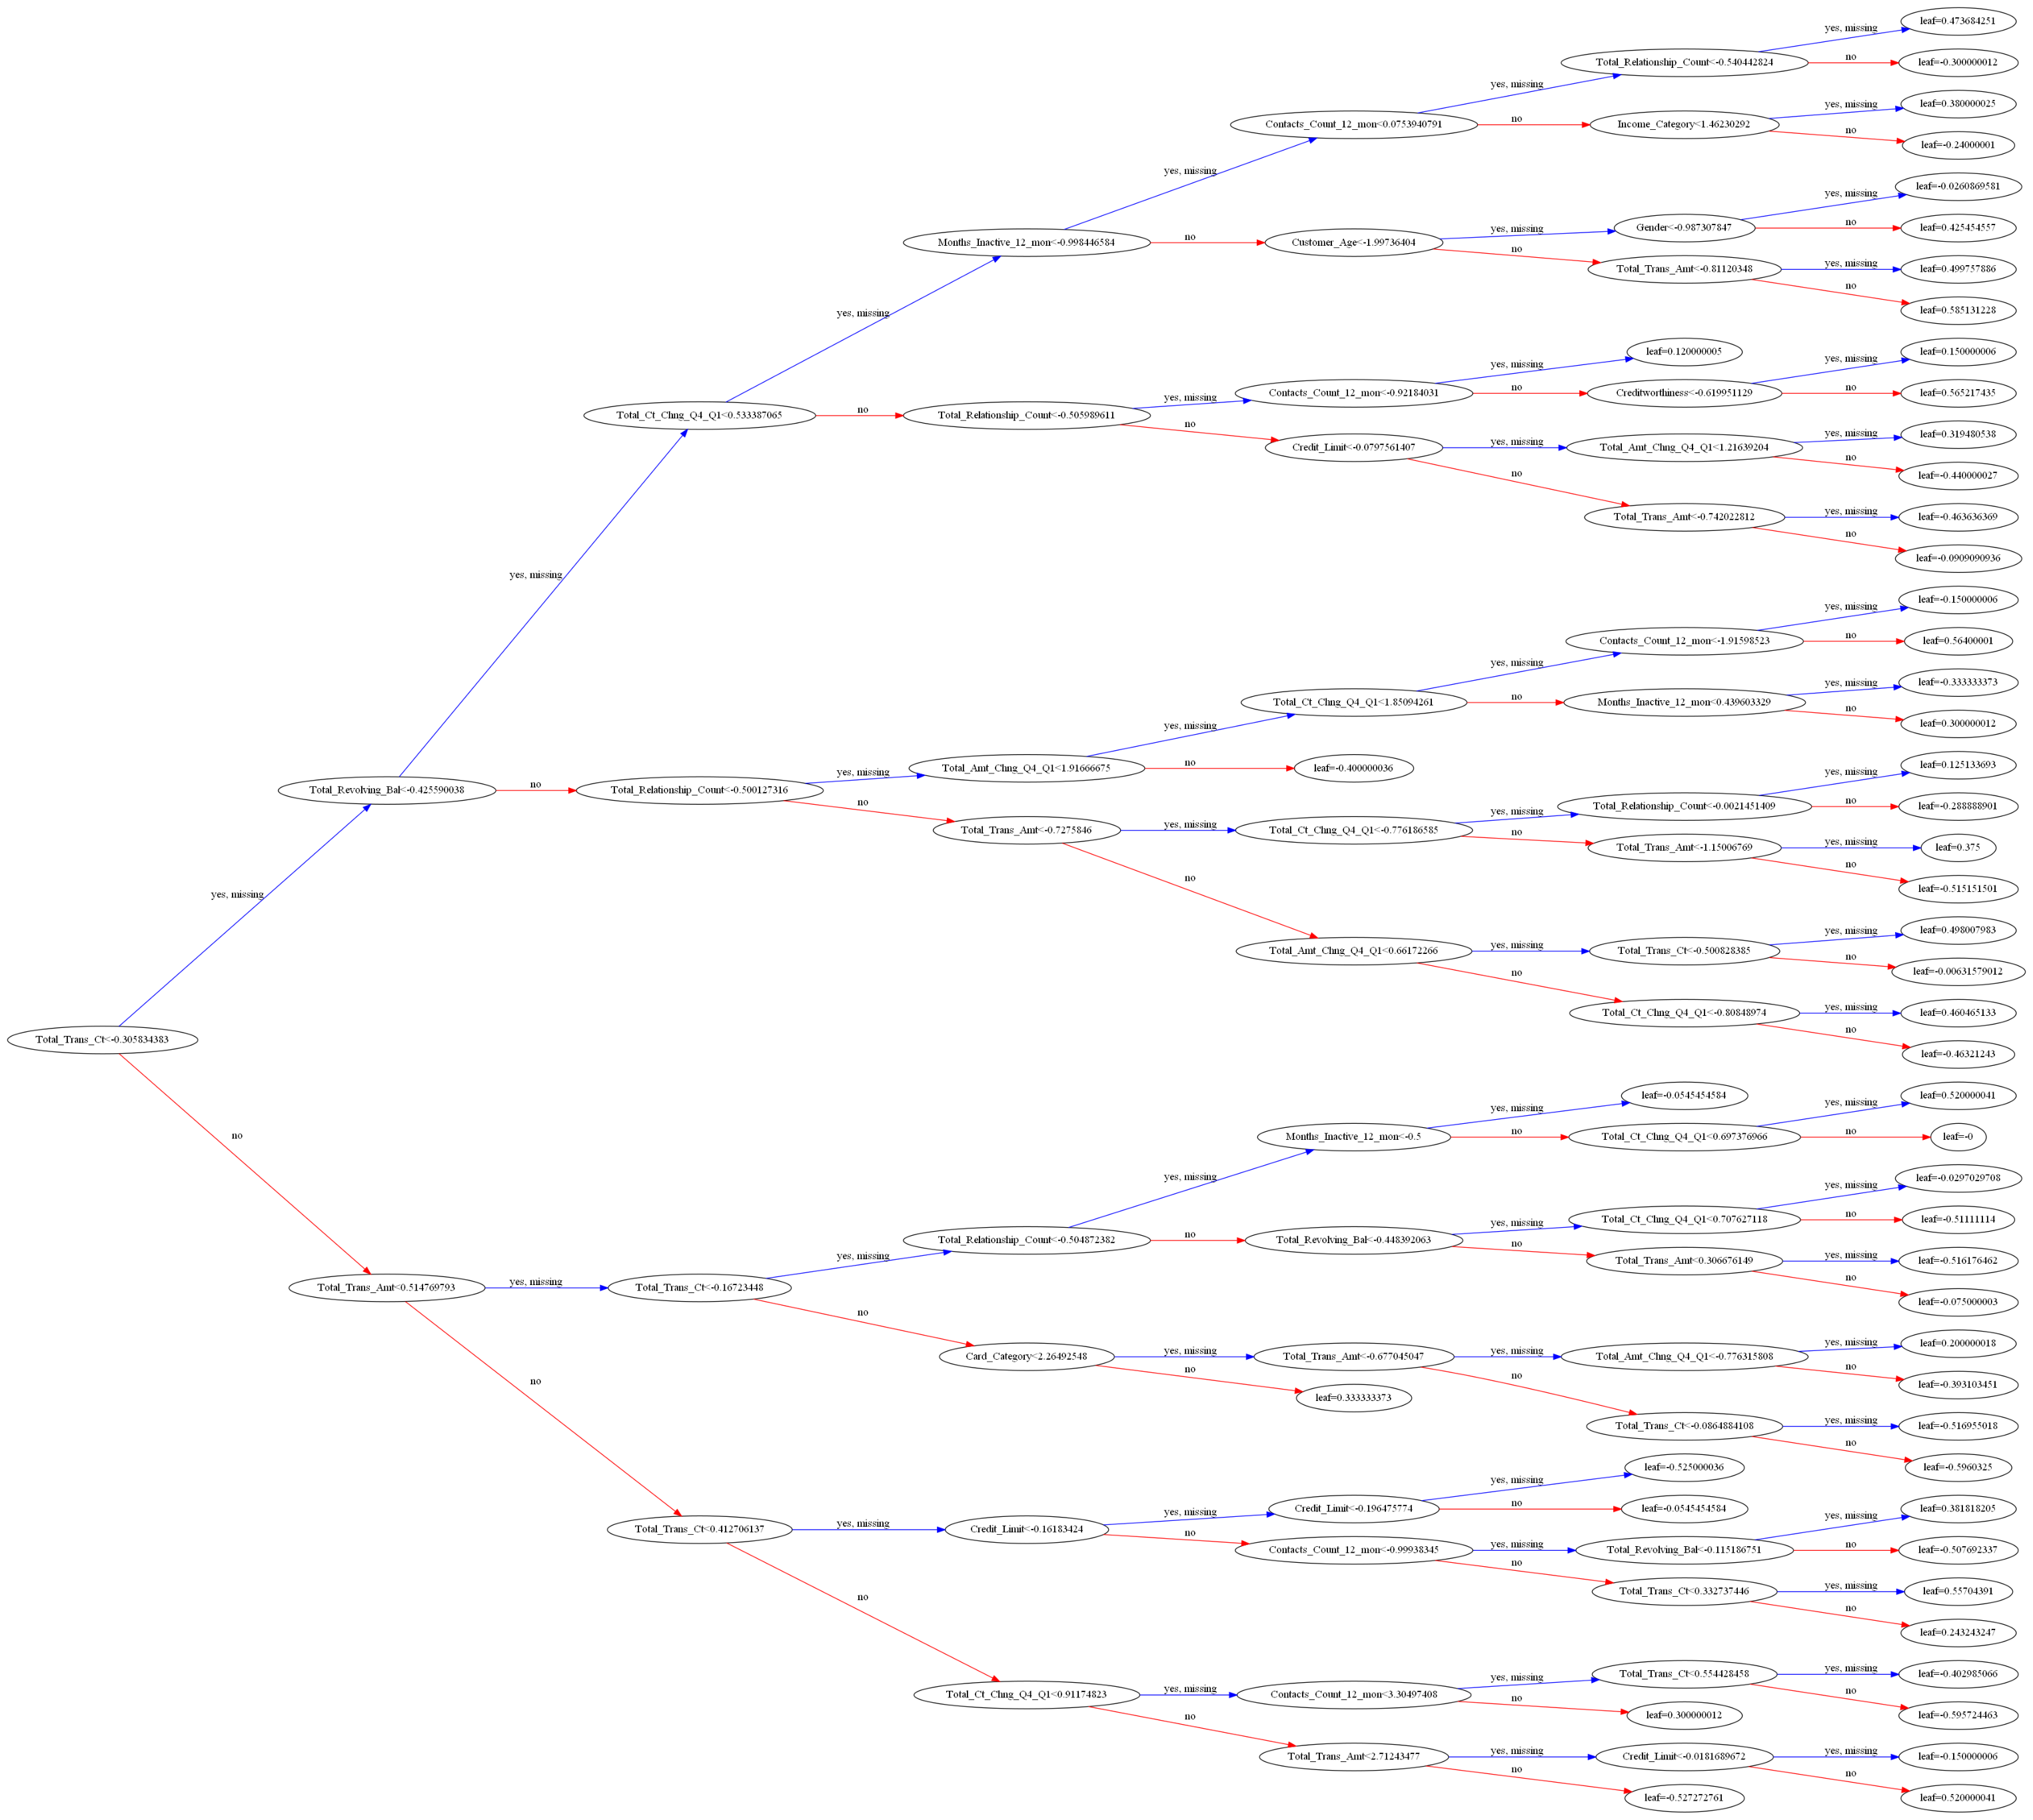

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50
plt.savefig("xgb_tree2.png", dpi=300);
#plot_tree(xgbmodel, num_trees=0);
plot_tree(xgbmodel.get_booster(), num_trees=0, rankdir='LR');